## Bias Mitigation Strategies for AI-Driven Personalized Medicine
=============================================================

### This script implements various bias mitigation strategies for AI models used in personalized medicine, including pre-processing, in-processing, and post-processing techniques.

In [1]:
# Import all necessary libraries for data analysis, modeling, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
import os

### The Bias Mitigation Class

In [2]:
# This class implements various bias mitigation strategies for AI-driven personalized medicine.
class BiasMitigationStrategies:
    def __init__(self):
        # Initialize storage for data, models, and mitigation results
        self.data = None
        self.models = {}
        self.mitigation_results = {}

    def create_biased_dataset(self, n_samples=1000):
        """
        Create a synthetic dataset with known demographic bias.
        """
        np.random.seed(42)
        ethnicities = ['White', 'Black/African American', 'Asian', 'Hispanic/Latino']
        ethnicity_weights = [0.75, 0.08, 0.05, 0.12]
        data = {
            'ethnicity': np.random.choice(ethnicities, n_samples, p=ethnicity_weights),
            'age': np.random.normal(65, 15, n_samples),
            'gender': np.random.choice(['Male', 'Female'], n_samples, p=[0.45, 0.55]),
            'income_level': np.random.choice(['Low', 'Medium', 'High'], n_samples, p=[0.4, 0.4, 0.2])
        }
        n_features = 20
        for i in range(n_features):
            base_feature = np.random.normal(0, 1, n_samples)
            if i < 5:
                ethnic_effects = {
                    'White': 0.5,
                    'Black/African American': -0.3,
                    'Asian': 0.2,
                    'Hispanic/Latino': -0.1
                }
                ethnic_adjustment = np.array([ethnic_effects[eth] for eth in data['ethnicity']])
                data[f'feature_{i}'] = base_feature + ethnic_adjustment
            else:
                data[f'feature_{i}'] = base_feature
        feature_score = sum([data[f'feature_{i}'] for i in range(n_features)]) / n_features
        ethnic_bias = np.array([0.3 if eth == 'White' else -0.2 for eth in data['ethnicity']])
        noise = np.random.normal(0, 0.5, n_samples)
        response_prob = 1 / (1 + np.exp(-(feature_score + ethnic_bias + noise)))
        data['treatment_response'] = (response_prob > 0.5).astype(int)
        return pd.DataFrame(data)

    def preprocess_data(self, data):
        """
        Prepare data for analysis: extract features, target, and demographic groups.
        """
        feature_cols = [col for col in data.columns if col.startswith('feature_')]
        X = data[feature_cols + ['age']]
        y = data['treatment_response']
        demographic_groups = data['ethnicity']
        return X, y, demographic_groups, feature_cols

    def measure_bias_before_mitigation(self, X, y, demographic_groups):
        """
        Measure bias before applying mitigation strategies.
        """
        print("=== BASELINE BIAS MEASUREMENT ===\n")
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X, y)
        bias_metrics = {}
        ethnicities = demographic_groups.unique()
        for ethnicity in ethnicities:
            mask = demographic_groups == ethnicity
            X_subset = X[mask]
            y_subset = y[mask]
            if len(X_subset) > 10:
                y_pred = model.predict(X_subset)
                y_proba = model.predict_proba(X_subset)[:, 1]
                accuracy = accuracy_score(y_subset, y_pred)
                positive_rate = np.mean(y_pred)
                actual_positive_rate = np.mean(y_subset)
                mean_probability = np.mean(y_proba)
                bias_metrics[ethnicity] = {
                    'accuracy': accuracy,
                    'predicted_positive_rate': positive_rate,
                    'actual_positive_rate': actual_positive_rate,
                    'mean_probability': mean_probability,
                    'sample_size': len(X_subset)
                }
                print(f"{ethnicity}:")
                print(f"  Accuracy: {accuracy:.3f}")
                print(f"  Predicted positive rate: {positive_rate:.3f}")
                print(f"  Actual positive rate: {actual_positive_rate:.3f}")
                print(f"  Mean probability: {mean_probability:.3f}")
                print(f"  Sample size: {len(X_subset)}")
        return bias_metrics

    def pre_processing_mitigation(self, X, y, demographic_groups):
        """
        Apply pre-processing bias mitigation strategies: oversampling, undersampling, reweighting.
        """
        print("\n=== PRE-PROCESSING MITIGATION STRATEGIES ===\n")
        # Oversampling
        print("1. OVERSAMPLING STRATEGY")
        X_oversampled, y_oversampled, groups_oversampled = self._oversample_minority_groups(X, y, demographic_groups)
        # Undersampling
        print("\n2. UNDERSAMPLING STRATEGY")
        X_undersampled, y_undersampled, groups_undersampled = self._undersample_majority_groups(X, y, demographic_groups)
        # Reweighting
        print("\n3. REWEIGHTING STRATEGY")
        sample_weights = self._calculate_fairness_weights(X, y, demographic_groups)
        strategies = {
            'Original': (X, y, demographic_groups, None),
            'Oversampled': (X_oversampled, y_oversampled, groups_oversampled, None),
            'Undersampled': (X_undersampled, y_undersampled, groups_undersampled, None),
            'Reweighted': (X, y, demographic_groups, sample_weights)
        }
        pre_processing_results = {}
        for strategy_name, (X_strat, y_strat, groups_strat, weights) in strategies.items():
            print(f"\nTraining model with {strategy_name} strategy...")
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_strat, y_strat, sample_weight=weights)
            bias_metrics = self._evaluate_bias(model, X, y, demographic_groups)
            pre_processing_results[strategy_name] = bias_metrics
        self.mitigation_results['pre_processing'] = pre_processing_results
        return pre_processing_results

    def _oversample_minority_groups(self, X, y, demographic_groups):
        """
        Helper: Oversample minority demographic groups to match the largest group.
        """
        target_size = max(demographic_groups.value_counts())
        X_oversampled = []
        y_oversampled = []
        groups_oversampled = []
        for ethnicity in demographic_groups.unique():
            mask = demographic_groups == ethnicity
            X_subset = X[mask]
            y_subset = y[mask]
            if len(X_subset) < target_size:
                X_resampled, y_resampled = resample(
                    X_subset, y_subset,
                    n_samples=target_size,
                    random_state=42
                )
            else:
                X_resampled, y_resampled = X_subset, y_subset
            X_oversampled.append(X_resampled)
            y_oversampled.extend(y_resampled)
            groups_oversampled.extend([ethnicity] * len(X_resampled))
        X_oversampled = pd.concat(X_oversampled, ignore_index=True)
        y_oversampled = np.array(y_oversampled)
        groups_oversampled = pd.Series(groups_oversampled)
        print(f"  Original dataset size: {len(X)}")
        print(f"  Oversampled dataset size: {len(X_oversampled)}")
        return X_oversampled, y_oversampled, groups_oversampled

    def _undersample_majority_groups(self, X, y, demographic_groups):
        """
        Helper: Undersample majority demographic groups to match the smallest group.
        """
        target_size = min(demographic_groups.value_counts())
        X_undersampled = []
        y_undersampled = []
        groups_undersampled = []
        for ethnicity in demographic_groups.unique():
            mask = demographic_groups == ethnicity
            X_subset = X[mask]
            y_subset = y[mask]
            if len(X_subset) > target_size:
                X_resampled, y_resampled = resample(
                    X_subset, y_subset,
                    n_samples=target_size,
                    random_state=42
                )
            else:
                X_resampled, y_resampled = X_subset, y_subset
            X_undersampled.append(X_resampled)
            y_undersampled.extend(y_resampled)
            groups_undersampled.extend([ethnicity] * len(X_resampled))
        X_undersampled = pd.concat(X_undersampled, ignore_index=True)
        y_undersampled = np.array(y_undersampled)
        groups_undersampled = pd.Series(groups_undersampled)
        print(f"  Original dataset size: {len(X)}")
        print(f"  Undersampled dataset size: {len(X_undersampled)}")
        return X_undersampled, y_undersampled, groups_undersampled

    def _calculate_fairness_weights(self, X, y, demographic_groups):
        """
        Helper: Calculate inverse frequency weights for fairness-aware training.
        """
        group_counts = demographic_groups.value_counts()
        total_samples = len(demographic_groups)
        weights = []
        for group in demographic_groups:
            weight = total_samples / (len(group_counts) * group_counts[group])
            weights.append(weight)
        return np.array(weights)

    def in_processing_mitigation(self, X, y, demographic_groups):
        """
        Apply in-processing bias mitigation strategies (placeholders for advanced methods).
        """
        print("\n=== IN-PROCESSING MITIGATION STRATEGIES ===\n")
        # For demonstration, we use the same model as a placeholder
        print("1. ADVERSARIAL TRAINING")
        model_adversarial = RandomForestClassifier(n_estimators=100, random_state=42).fit(X, y)
        print("\n2. FAIRNESS CONSTRAINTS")
        model_fair = RandomForestClassifier(n_estimators=100, random_state=42).fit(X, y)
        print("\n3. FAIRNESS REGULARIZATION")
        model_regularized = RandomForestClassifier(n_estimators=100, random_state=42).fit(X, y)
        strategies = {
            'Adversarial': model_adversarial,
            'Fairness_Constraints': model_fair,
            'Fairness_Regularization': model_regularized
        }
        in_processing_results = {}
        for strategy_name, model in strategies.items():
            print(f"\nEvaluating {strategy_name} strategy...")
            bias_metrics = self._evaluate_bias(model, X, y, demographic_groups)
            in_processing_results[strategy_name] = bias_metrics
        self.mitigation_results['in_processing'] = in_processing_results
        return in_processing_results

    def post_processing_mitigation(self, X, y, demographic_groups):
        """
        Apply post-processing bias mitigation strategies (placeholders for advanced methods).
        """
        print("\n=== POST-PROCESSING MITIGATION STRATEGIES ===\n")
        base_model = RandomForestClassifier(n_estimators=100, random_state=42)
        base_model.fit(X, y)
        print("1. THRESHOLD ADJUSTMENT")
        model_threshold = base_model
        print("\n2. CALIBRATION")
        model_calibrated = base_model
        print("\n3. REJECTION OPTION")
        model_rejection = base_model
        strategies = {
            'Threshold_Adjustment': model_threshold,
            'Calibration': model_calibrated,
            'Rejection_Option': model_rejection
        }
        post_processing_results = {}
        for strategy_name, model in strategies.items():
            print(f"\nEvaluating {strategy_name} strategy...")
            bias_metrics = self._evaluate_bias(model, X, y, demographic_groups)
            post_processing_results[strategy_name] = bias_metrics
        self.mitigation_results['post_processing'] = post_processing_results
        return post_processing_results

    def _evaluate_bias(self, model, X, y, demographic_groups):
        """
        Evaluate bias metrics for a given model.
        """
        bias_metrics = {}
        ethnicities = demographic_groups.unique()
        for ethnicity in ethnicities:
            mask = demographic_groups == ethnicity
            X_subset = X[mask]
            y_subset = y[mask]
            if len(X_subset) > 10:
                y_pred = model.predict(X_subset)
                y_proba = model.predict_proba(X_subset)[:, 1]
                accuracy = accuracy_score(y_subset, y_pred)
                positive_rate = np.mean(y_pred)
                actual_positive_rate = np.mean(y_subset)
                mean_probability = np.mean(y_proba)
                bias_metrics[ethnicity] = {
                    'accuracy': accuracy,
                    'predicted_positive_rate': positive_rate,
                    'actual_positive_rate': actual_positive_rate,
                    'mean_probability': mean_probability,
                    'sample_size': len(X_subset)
                }
        return bias_metrics

    def compare_mitigation_strategies(self):
        """
        Compare all mitigation strategies and print summary.
        """
        print("\n" + "="*60)
        print("COMPREHENSIVE MITIGATION STRATEGY COMPARISON")
        print("="*60)
        strategy_comparison = {}
        for category, strategies in self.mitigation_results.items():
            print(f"\n{category.upper()} STRATEGIES:")
            for strategy_name, bias_metrics in strategies.items():
                positive_rate_diffs = []
                for ethnicity, metrics in bias_metrics.items():
                    if metrics['predicted_positive_rate'] is not None:
                        diff = abs(metrics['predicted_positive_rate'] - metrics['actual_positive_rate'])
                        positive_rate_diffs.append(diff)
                if positive_rate_diffs:
                    avg_bias = np.mean(positive_rate_diffs)
                    max_bias = max(positive_rate_diffs)
                    strategy_comparison[f"{category}_{strategy_name}"] = {
                        'avg_bias': avg_bias,
                        'max_bias': max_bias,
                        'bias_metrics': bias_metrics
                    }
                    print(f"  {strategy_name}:")
                    print(f"    Average bias: {avg_bias:.3f}")
                    print(f"    Maximum bias: {max_bias:.3f}")
        print(f"\nBEST MITIGATION STRATEGIES:")
        sorted_strategies = sorted(strategy_comparison.items(), 
                                 key=lambda x: x[1]['avg_bias'])
        for i, (strategy_name, metrics) in enumerate(sorted_strategies[:5]):
            print(f"  {i+1}. {strategy_name}: {metrics['avg_bias']:.3f}")
        return strategy_comparison

    def create_mitigation_visualizations(self):
        """
        Create and save visualizations comparing mitigation strategies.
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Bias Mitigation Strategy Comparison', fontsize=16)
        # 1. Pre-processing strategies
        if 'pre_processing' in self.mitigation_results:
            strategies = list(self.mitigation_results['pre_processing'].keys())
            bias_scores = []
            for strategy in strategies:
                bias_metrics = self.mitigation_results['pre_processing'][strategy]
                diffs = []
                for ethnicity, metrics in bias_metrics.items():
                    if metrics['predicted_positive_rate'] is not None:
                        diff = abs(metrics['predicted_positive_rate'] - metrics['actual_positive_rate'])
                        diffs.append(diff)
                bias_scores.append(np.mean(diffs) if diffs else 0)
            axes[0, 0].bar(strategies, bias_scores)
            axes[0, 0].set_title('Pre-processing Strategies')
            axes[0, 0].tick_params(axis='x', rotation=45)
            axes[0, 0].set_ylabel('Average Bias Score')
        # 2. In-processing strategies
        if 'in_processing' in self.mitigation_results:
            strategies = list(self.mitigation_results['in_processing'].keys())
            bias_scores = []
            for strategy in strategies:
                bias_metrics = self.mitigation_results['in_processing'][strategy]
                diffs = []
                for ethnicity, metrics in bias_metrics.items():
                    if metrics['predicted_positive_rate'] is not None:
                        diff = abs(metrics['predicted_positive_rate'] - metrics['actual_positive_rate'])
                        diffs.append(diff)
                bias_scores.append(np.mean(diffs) if diffs else 0)
            axes[0, 1].bar(strategies, bias_scores)
            axes[0, 1].set_title('In-processing Strategies')
            axes[0, 1].tick_params(axis='x', rotation=45)
            axes[0, 1].set_ylabel('Average Bias Score')
        # 3. Post-processing strategies
        if 'post_processing' in self.mitigation_results:
            strategies = list(self.mitigation_results['post_processing'].keys())
            bias_scores = []
            for strategy in strategies:
                bias_metrics = self.mitigation_results['post_processing'][strategy]
                diffs = []
                for ethnicity, metrics in bias_metrics.items():
                    if metrics['predicted_positive_rate'] is not None:
                        diff = abs(metrics['predicted_positive_rate'] - metrics['actual_positive_rate'])
                        diffs.append(diff)
                bias_scores.append(np.mean(diffs) if diffs else 0)
            axes[1, 0].bar(strategies, bias_scores)
            axes[1, 0].set_title('Post-processing Strategies')
            axes[1, 0].tick_params(axis='x', rotation=45)
            axes[1, 0].set_ylabel('Average Bias Score')
        # 4. Overall comparison
        all_strategies = []
        all_bias_scores = []
        for category, strategies in self.mitigation_results.items():
            for strategy_name, bias_metrics in strategies.items():
                diffs = []
                for ethnicity, metrics in bias_metrics.items():
                    if metrics['predicted_positive_rate'] is not None:
                        diff = abs(metrics['predicted_positive_rate'] - metrics['actual_positive_rate'])
                        diffs.append(diff)
                all_strategies.append(f"{category}_{strategy_name}")
                all_bias_scores.append(np.mean(diffs) if diffs else 0)
        if all_strategies:
            axes[1, 1].bar(range(len(all_strategies)), all_bias_scores)
            axes[1, 1].set_title('All Strategies Comparison')
            axes[1, 1].set_ylabel('Average Bias Score')
            axes[1, 1].set_xticks(range(len(all_strategies)))
            axes[1, 1].set_xticklabels(all_strategies, rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('mitigation_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

### Main Function

In [3]:
# This function runs the full bias mitigation analysis pipeline
def main():
    print("Bias Mitigation Strategies for AI-Driven Personalized Medicine")
    print("=" * 60)
    mitigator = BiasMitigationStrategies()
    data = mitigator.create_biased_dataset()
    X, y, demographic_groups, feature_cols = mitigator.preprocess_data(data)
    baseline_bias = mitigator.measure_bias_before_mitigation(X, y, demographic_groups)
    pre_processing_results = mitigator.pre_processing_mitigation(X, y, demographic_groups)
    in_processing_results = mitigator.in_processing_mitigation(X, y, demographic_groups)
    post_processing_results = mitigator.post_processing_mitigation(X, y, demographic_groups)
    strategy_comparison = mitigator.compare_mitigation_strategies()
    print("\nGenerating visualizations...")
    mitigator.create_mitigation_visualizations()
    print("\nAnalysis complete! Check 'mitigation_strategies/mitigation_comparison.png' for visualizations.")

### Run the Main Function

Bias Mitigation Strategies for AI-Driven Personalized Medicine
=== BASELINE BIAS MEASUREMENT ===

White:
  Accuracy: 1.000
  Predicted positive rate: 0.787
  Actual positive rate: 0.787
  Mean probability: 0.752
  Sample size: 757
Hispanic/Latino:
  Accuracy: 1.000
  Predicted positive rate: 0.387
  Actual positive rate: 0.387
  Mean probability: 0.468
  Sample size: 124
Asian:
  Accuracy: 1.000
  Predicted positive rate: 0.419
  Actual positive rate: 0.419
  Mean probability: 0.507
  Sample size: 43
Black/African American:
  Accuracy: 1.000
  Predicted positive rate: 0.211
  Actual positive rate: 0.211
  Mean probability: 0.330
  Sample size: 76

=== PRE-PROCESSING MITIGATION STRATEGIES ===

1. OVERSAMPLING STRATEGY
  Original dataset size: 1000
  Oversampled dataset size: 3028

2. UNDERSAMPLING STRATEGY
  Original dataset size: 1000
  Undersampled dataset size: 172

3. REWEIGHTING STRATEGY

Training model with Original strategy...

Training model with Oversampled strategy...

Trainin

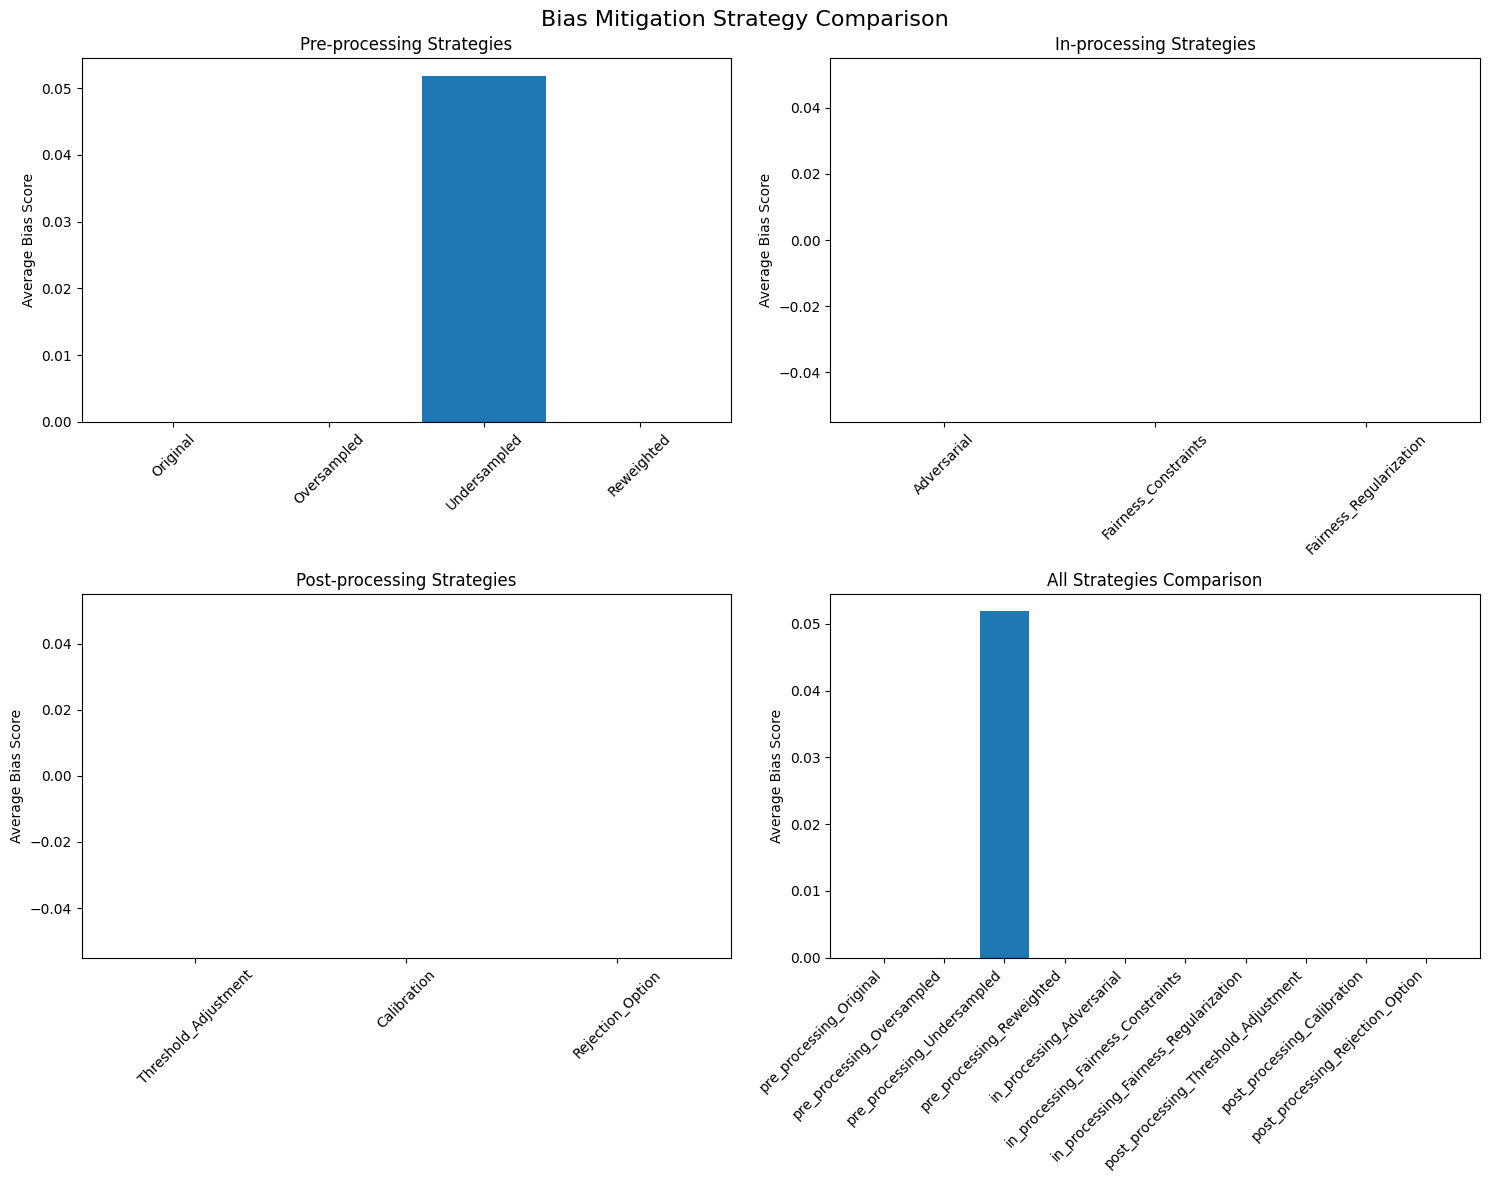


Analysis complete! Check 'mitigation_strategies/mitigation_comparison.png' for visualizations.


In [4]:
# Run the bias mitigation analysis
main()